# Final Project
Yashada Apte
C0856941

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

In [2]:
df = pd.read_csv("US-Economic-News.csv" , encoding = "ISO-8859-1" )
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction import _stop_words
print('sklearn stopwords :',len(_stop_words.ENGLISH_STOP_WORDS))

from nltk.corpus import stopwords
print('NLTK Stopwords :',len(stopwords.words('english')))

sklearn stopwords : 318
NLTK Stopwords : 179


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

In [5]:
df["relevance"].value_counts()/df.shape[0]


no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [6]:
# convert label to a numerical variable
df1 = df[df.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
print(df1.shape)
df1['relevance'] = df1.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 
df2 = df1[["text","relevance"]] # Let us take only the two columns we need.
df2.shape

(7991, 15)


(7991, 2)

In [7]:
Stopwords = _stop_words.ENGLISH_STOP_WORDS

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in Stopwords])
    # remove punctuation and numbers
    return doc


In [8]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = df2.text # the column text contains textual data to extract features from
y = df2.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [9]:
# # COUNTVECTORIZER
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)


(5993, 49753) (1998, 49753)


In [10]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

In [14]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced") # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

Accuracy:  0.7357357357357357
AUC:  0.5807271802695144


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 576x432 with 0 Axes>

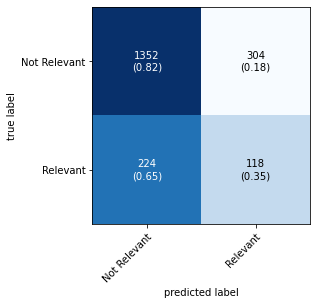

In [25]:
from sklearn.metrics import roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_class))
acc_logreg=accuracy_score(y_test,y_pred_class)
roc_curve_logreg = roc_auc_score(y_test, y_pred_class)
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, class_names=['Not Relevant','Relevant'], show_normed=True)

In [26]:
# SVC
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

Accuracy:  0.6926926926926927
AUC:  0.6197241291634884


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 576x432 with 0 Axes>

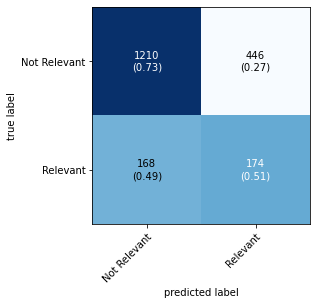

In [28]:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_class))
acc_svc=accuracy_score(y_test,y_pred_class)
roc_curve_svc = roc_auc_score(y_test, y_pred_class)
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, class_names=['Not Relevant','Relevant'],show_normed=True)

In [29]:
models = ["Logistic Regression", "SVC"]
data={"Accuracy":[acc_logreg,acc_svc],
      "ROC_AUC":[roc_curve_logreg,roc_curve_svc]}

result=pd.DataFrame(data=data,index=models)
result


,Accuracy,ROC_AUC
Logistic Regression,0.735736,0.580727
SVC,0.692693,0.619724
